# Multiclass Classification: Newswires
For binary classification we classified vector inputs into two mutually exclusive classes using a densely-connected neural network. 

Now, we classify Reuters newswires into 46 mutually exclusive topics. This will be *single-label, multiclass classification*  since each input will belong to one topic. 

Data set is built-in with Keras: we examine the Reuters newswires published in 1986. Each topic (of the 46) has at least 10 examples in the training set.

Code based on example by Francois Chollet in *Deep Learning with Python, Second Edition*.

In [2]:
# Only use 10,000 most frequently used words.
from tensorflow.keras.datasets import reuters
(trainData, trainLabels), (testData, testLabels) = reuters.load_data(num_words=10_000)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print(f'Length of training data: {len(trainData)}.')
print(f'Lenth of test data: {len(testData)}.')

Length of training data: 8982.
Lenth of test data: 2246.


In [4]:
# Vectorize data with same code used in binary classification:
#  (one-hot encode it)
import numpy as np
def vectorize_sequences(sequences, dimension=10_000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # One-hot words occuring in sequence.
    return results

xTrain = vectorize_sequences(trainData)
xTest = vectorize_sequences(testData)

In [7]:
# Vectorize (one-hot) labels with Keras:
from tensorflow.keras.utils import to_categorical
oneHotTrainLabels = to_categorical(trainLabels)
oneHotTestLabels = to_categorical(testLabels)


# Function to achieve same thing (one-hot labels):
def one_hot(labels, dim):
  results = np.zeros((len(labels), dim))
  for i, label in enumerate(labels):
    results[i, label] = 1. # One-hot (float) label in labels.
  return results

## Build the model
Dimension of output space is now 46, up from 2 in binary classification.

Note using 16-dimensional space for a layer as we did in binary classification may lead to information bottleneck since we are separating 46 ways. Try 64-unit `Dense` layers.

Again we want a kind of probability output, but instead of `sigmoid` activation for binary classifying, we use `softmax`, a probabilty distribution which we set to account for 46 topics. `softmax` will produce a 46D vector such that `output[i]` is probability the sample belongs to topic `i`. Each vector, since they are probabilties, sum to 1. 

In [22]:
# Define model:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax') # Size output layer is 46 for 46 topics
])

For loss function, we use `categorical_crossentropy` (instead of `binary_crossentropy` like in binary classification) which measures the distance between two probability distributions. It will minimize distance between probabilty distribution of the output and the true distribution of the labels.

In [23]:
# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Set aside 1,000 samples of training data to use as a validation set
xVal = xTrain[:1000]
xPartialTrain = xTrain[1000:]
yVal = oneHotTrainLabels[:1000]
yPartialTrain = oneHotTrainLabels[1000:]

In [25]:
# Train model 20 epochs
history = model.fit(xPartialTrain,
                    yPartialTrain,
                    epochs=20,
                    batch_size=512,
                    validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 24ms/step - loss: 3.1291 - accuracy: 0.4299 - val_loss: 1.7361 - val_accuracy: 0.6440
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.4861 - accuracy: 0.7008 - val_loss: 1.3036 - val_accuracy: 0.7260
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0654 - accuracy: 0.7747 - val_loss: 1.1279 - val_accuracy: 0.7530
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8204 - accuracy: 0.8292 - val_loss: 1.0141 - val_accuracy: 0.7860
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6443 - accuracy: 0.8686 - val_loss: 0.9532 - val_accuracy: 0.8010
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5062 - accuracy: 0.8928 - val_loss: 0.9403 - val_accuracy: 0.8060
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.4059 - accuracy: 0.9213 - val_loss: 0.9047 - val_accuracy: 0.8090
Epoch 8/20
16

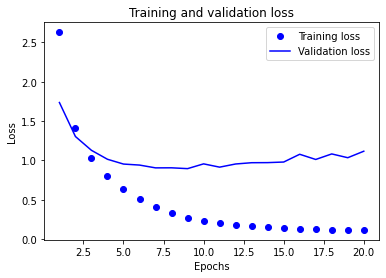

In [26]:
import matplotlib.pyplot as plt

# Plot training and validation loss
lossValues = history.history['loss']
val_lossValues = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, lossValues, 'bo', label='Training loss')
plt.plot(epochs, val_lossValues, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

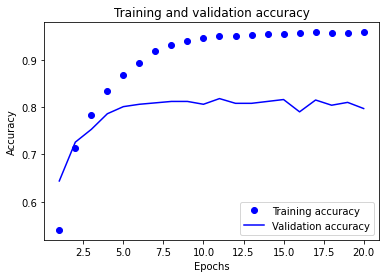

In [27]:
# Plot training and validation accuracy
plt.clf()
accValues = history.history['accuracy']
val_accValues = history.history['val_accuracy']
plt.plot(epochs, accValues, 'bo', label='Training accuracy')
plt.plot(epochs, val_accValues, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Overfitting after 9 epochs (val_loss = 0.8950)
#  new model, evaluate it on the test set.
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=9,
          batch_size=512,
          validation_data=(xVal, yVal))
results = model.evaluate(xTest, oneHotTestLabels)

Epoch 1/9
16/16 [==============================] - 1s 25ms/step - loss: 3.1181 - accuracy: 0.3924 - val_loss: 1.7122 - val_accuracy: 0.6170
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.5192 - accuracy: 0.6858 - val_loss: 1.2861 - val_accuracy: 0.7160
Epoch 3/9
16/16 [==============================] - 0s 15ms/step - loss: 1.0768 - accuracy: 0.7710 - val_loss: 1.1291 - val_accuracy: 0.7560
Epoch 4/9
16/16 [==============================] - 0s 15ms/step - loss: 0.8417 - accuracy: 0.8160 - val_loss: 1.0416 - val_accuracy: 0.7750
Epoch 5/9
16/16 [==============================] - 0s 15ms/step - loss: 0.6534 - accuracy: 0.8638 - val_loss: 1.0228 - val_accuracy: 0.7830
Epoch 6/9
16/16 [==============================] - 0s 16ms/step - loss: 0.5322 - accuracy: 0.8916 - val_loss: 0.9501 - val_accuracy: 0.7960
Epoch 7/9
16/16 [==============================] - 0s 15ms/step - loss: 0.4187 - accuracy: 0.9145 - val_loss: 0.9334 - val_accuracy: 0.7960
Epoch 8/9
16/16 [===

In [30]:
print("Achieved accuracy of %d precent." % (round(results[1]*100)))

Achieved accuracy of 79 precent.


If we were working with binary classification, the accuracy of a random classifier would be 50%. What would it be for a multiclass classifier like this one with 46 classes?

In [36]:
# Accuracy of a random baseline?
import copy
testLabelsCopy = copy.copy(testLabels)
np.random.shuffle(testLabelsCopy)
hitsArray = np.array(testLabels) == np.array(testLabelsCopy)
accuracy = float(np.sum(hitsArray) / len(testLabels))
print("Random accuracy of this 46 class multiclass classifier is roughly %.2f percent." % (accuracy*100))

Random accuracy of this 46 class multiclass classifier is roughly 18.88 percent.


In [38]:
# Generate topic predictions for all of the test data:
predictions = model.predict(xTest)

In [39]:
# See that prediction vector is 46D
predictions[0].shape

(46,)

In [41]:
print(f"Sum of 46 elements in predictions vector is: {np.sum(predictions[0])}")

Sum of 46 elements in predictions vector is: 0.9999998211860657


In [43]:
print(f"For predictions[0], the class (topic) number predicted is {np.argmax(predictions[0])}.")

For predictions[0], the class (topic) number predicted is 3.


## Does bottleneck occur when we use smaller than 64-unit `Dense` layer?

In [49]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='relu'), # Bottleneck?
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 3.5028 - accuracy: 0.3107 - val_loss: 2.8289 - val_accuracy: 0.3570
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 2.6877 - accuracy: 0.3586 - val_loss: 2.4527 - val_accuracy: 0.3540
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 2.3265 - accuracy: 0.3599 - val_loss: 2.2450 - val_accuracy: 0.3690
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 2.1140 - accuracy: 0.3749 - val_loss: 2.0758 - val_accuracy: 0.3810
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 1.8947 - accuracy: 0.3956 - val_loss: 1.8977 - val_accuracy: 0.3990
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 1.7033 - accuracy: 0.4894 - val_loss: 1.7473 - val_accuracy: 0.5710
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 1.5252 - accuracy: 0.6361 - val_loss: 1.6065 - val_accuracy: 0.6280
Epoch 8/20
16

Validation accuracy is at best roughly 72%, significantly less than our 81% accuracy with 64-unit `Dense` layers.

## Try different number of units and intermediate layers
There aren't any enormous discrepencies while changing these parameters, but a maximum difference of 3% between worst and best choice of number of units and number of intermediate layers is worth sorting out. 

In [50]:
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 26ms/step - loss: 2.6950 - accuracy: 0.4488 - val_loss: 1.3943 - val_accuracy: 0.6920
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.1783 - accuracy: 0.7412 - val_loss: 1.0990 - val_accuracy: 0.7610
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8084 - accuracy: 0.8306 - val_loss: 1.0256 - val_accuracy: 0.7650
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5874 - accuracy: 0.8766 - val_loss: 0.9052 - val_accuracy: 0.8120
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.4122 - accuracy: 0.9170 - val_loss: 0.9398 - val_accuracy: 0.8030
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 0.3207 - accuracy: 0.9322 - val_loss: 0.8777 - val_accuracy: 0.8310
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.2436 - accuracy: 0.9448 - val_loss: 0.8847 - val_accuracy: 0.8190
Epoch 8/20
16

128-unit `Dense` layers as 2 intermediate layers peaks around 83% validation accuracy.

In [51]:
model = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 3.4465 - accuracy: 0.2804 - val_loss: 2.4374 - val_accuracy: 0.5600
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 2.1862 - accuracy: 0.5853 - val_loss: 1.7328 - val_accuracy: 0.6710
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.5371 - accuracy: 0.7091 - val_loss: 1.4327 - val_accuracy: 0.6990
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 1.2558 - accuracy: 0.7470 - val_loss: 1.2724 - val_accuracy: 0.7340
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0489 - accuracy: 0.7851 - val_loss: 1.1762 - val_accuracy: 0.7580
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8450 - accuracy: 0.8257 - val_loss: 1.1185 - val_accuracy: 0.7660
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.7512 - accuracy: 0.8426 - val_loss: 1.0657 - val_accuracy: 0.7780
Epoch 8/20
16

32-unit `Dense` layers as 2 intermediate layers peaks around 80% validation accuracy.

In [52]:
model = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 24ms/step - loss: 3.2749 - accuracy: 0.4043 - val_loss: 2.3031 - val_accuracy: 0.6370
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 2.0405 - accuracy: 0.6641 - val_loss: 1.7458 - val_accuracy: 0.6700
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.5194 - accuracy: 0.7102 - val_loss: 1.4379 - val_accuracy: 0.7050
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 1.2096 - accuracy: 0.7582 - val_loss: 1.2602 - val_accuracy: 0.7270
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 1.0065 - accuracy: 0.7939 - val_loss: 1.1490 - val_accuracy: 0.7570
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8671 - accuracy: 0.8197 - val_loss: 1.0676 - val_accuracy: 0.7720
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.7358 - accuracy: 0.8511 - val_loss: 1.0090 - val_accuracy: 0.7890
Epoch 8/20
16

32-unit `Dense` layer as 1 intermediate layer peaks above 82% validation accuracy.

In [53]:
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 24ms/step - loss: 2.8031 - accuracy: 0.4673 - val_loss: 1.4797 - val_accuracy: 0.6940
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.2174 - accuracy: 0.7585 - val_loss: 1.1123 - val_accuracy: 0.7720
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8404 - accuracy: 0.8314 - val_loss: 0.9632 - val_accuracy: 0.8020
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6093 - accuracy: 0.8821 - val_loss: 0.8901 - val_accuracy: 0.8090
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.4586 - accuracy: 0.9105 - val_loss: 0.8447 - val_accuracy: 0.8230
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.3461 - accuracy: 0.9303 - val_loss: 0.8154 - val_accuracy: 0.8270
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.2737 - accuracy: 0.9429 - val_loss: 0.8094 - val_accuracy: 0.8320
Epoch 8/20
16

128-unit Dense layer as 1 intermediate layer peaks around 82% validation accuracy.


In [54]:
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 27ms/step - loss: 2.8449 - accuracy: 0.3811 - val_loss: 1.4644 - val_accuracy: 0.6840
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.2439 - accuracy: 0.7215 - val_loss: 1.2612 - val_accuracy: 0.7230
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 0.9036 - accuracy: 0.7990 - val_loss: 1.0734 - val_accuracy: 0.7730
Epoch 4/20
16/16 [==============================] - 0s 17ms/step - loss: 0.6318 - accuracy: 0.8603 - val_loss: 1.2052 - val_accuracy: 0.7170
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.5084 - accuracy: 0.8835 - val_loss: 0.9003 - val_accuracy: 0.8200
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.3431 - accuracy: 0.9258 - val_loss: 0.9401 - val_accuracy: 0.8100
Epoch 7/20
16/16 [==============================] - 0s 17ms/step - loss: 0.2585 - accuracy: 0.9438 - val_loss: 0.9806 - val_accuracy: 0.8090
Epoch 8/20
16

128-unit Dense layer as 3 intermediate layers peaks around 82% validation accuracy.

In [55]:
model = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(xPartialTrain,
          yPartialTrain,
          epochs=20,
          batch_size=512,
          validation_data=(xVal, yVal))

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 3.6230 - accuracy: 0.1041 - val_loss: 2.6620 - val_accuracy: 0.5690
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 2.3361 - accuracy: 0.5785 - val_loss: 1.7996 - val_accuracy: 0.5830
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.6272 - accuracy: 0.6258 - val_loss: 1.4979 - val_accuracy: 0.6640
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 1.3260 - accuracy: 0.7045 - val_loss: 1.3458 - val_accuracy: 0.6920
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 1.1373 - accuracy: 0.7366 - val_loss: 1.2227 - val_accuracy: 0.7230
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.9418 - accuracy: 0.7858 - val_loss: 1.1467 - val_accuracy: 0.7420
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8214 - accuracy: 0.8209 - val_loss: 1.0865 - val_accuracy: 0.7550
Epoch 8/20
16

32-unit Dense layer as 3 intermediate layers peaks around 80% validation accuracy.